## Date Processing

Because more than 6000 out of 27060 games have total ratings < 10, using rating algorithm from https://steamdb.info/blog/steamdb-rating/ to minimize bias.

$Review Score = \frac{Positive Ratings}{Total Ratings}$

$Rating = Review Score - (Review Score - 0.5)*2^{-log_{10}(Total Ratings + 1)}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [96]:
def data_process():
    '''
    Cleaning, transforming the data, adding necessary columns for later analysis
    :return: df: pd.Dataframe
    '''
    import datetime as dt
    
    steamspy_df = pd.read_csv("steamspy_data.csv")
    steam_df = pd.read_csv("steam.csv")
    
    #convert price in GBP to USD by merging data from another dataframe
    steamspy_df['initialprice'] = steamspy_df['initialprice']/100
    steamspy_temp = steamspy_df.loc[:, ['appid', 'initialprice']]
    df = pd.merge(steam_df,steamspy_temp,on='appid').drop('price', axis=1)
    df.rename(columns={'initialprice':'price'}, inplace=True)
    assert sum(df['price'].isna())==0
    
    #calculate total ratings and positive rating percentage using postive & negative ratings
    df['total_ratings'] = df['positive_ratings']+df['negative_ratings']
    df['rating_score'] = df['positive_ratings']/df['total_ratings']
    #calculate rating using rating algorithm above
    df['rating'] = df['rating_score']-(df['rating_score']-0.5)*2**(-np.log10(df['total_ratings'] + 1))
    
    #add release_year column
    yr=pd.to_datetime(df['release_date'])
    df['release_year'] = yr.dt.strftime('%Y')
    
    #convert owners interval to midpoint of the interval
    df['owners'] = df['owners'].str.split(pat='-').apply(lambda x: int((int(x[0])+int(x[1]))/2))
    
    #encode popular categories/genres to individual binary columns
    pop_cat = ['Single-player','Multi-player']
    pop_genre = ['Action','Adventure','Casual','FPS','Indie','Racing','RPG','Simulation','Sports','Strategy']
    for cat in pop_cat:
        df[cat] = np.where(df['categories'].str.contains(cat), 1, 0)
        assert df[cat].sum()>0
    for gen in pop_genre:
        if gen=='FPS':
            df[gen] = np.where(df['steamspy_tags'].str.contains(gen), 1, 0)
        else:
            df[gen] = np.where(df['genres'].str.contains(gen), 1, 0)
        assert df[gen].sum()>0

    
    #parse developers and only take first in list
    df['developer']=df['developer'].str.split(pat=';').apply(lambda x: x[0])
    df['publisher']=df['publisher'].str.split(pat=';').apply(lambda x: x[0])
    
    return df
    
    
df = data_process()
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,Action,Adventure,Casual,FPS,Indie,Racing,RPG,Simulation,Sports,Strategy
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-Player;Valve Anti-Cheat enabled,Action,...,1,0,0,1,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-Player;Valve Anti-Cheat enabled,Action,...,1,0,0,1,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,1,0,0,1,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-Player;Valve Anti-Cheat enabled,Action,...,1,0,0,1,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat enabled,Action,...,1,0,0,1,0,0,0,0,0,0


In [3]:
sum(df['total_ratings']<10)

6564

## Developers and publishers Analysis

### Top 10 developers

In [81]:
def dev_score(df):
    '''
    Calculate score for developers based on 20% avg # of game released,20% avg owners, 20% avg total reviews, 40% avg ratings
    :return: df: pd.Dateframe
    '''
    from scipy import stats
    df['dev_score'] = (0.2*stats.zscore(np.log10(df['game_num']))+0.2*stats.zscore(np.log10(df['sum_owners']))+0.2*stats.zscore(np.log10(df['avg_total_ratings']))+0.4*stats.zscore(df['avg_rating']))/5
    return df

In [82]:
#pivot table for developers
dev_table = pd.pivot_table(df,index='developer', values=['appid','price','total_ratings','rating','owners'], 
    aggfunc={'appid':'count','price':np.mean,'total_ratings':np.mean,'rating':np.mean,'owners':np.sum}).rename(
    {'appid':'game_num','price':'avg_price','total_ratings':'avg_total_ratings','rating':'avg_rating','owners':'sum_owners'}, axis=1)

dev_score(dev_table)
top_dev = dev_table.sort_values('dev_score', ascending=False).head(10)
top_dev

#dev_table.query('developer=="Valve"')
#df[df['developer'].str.lower().str.contains("capcom")].head(50)

,game_num,sum_owners,avg_price,avg_rating,avg_total_ratings,dev_score
developer,,,,,,
Valve,27,480750000,6.696296,0.869256,204476.814815,0.794117
Bethesda Game Studios,10,37050000,26.991000,0.810354,56177.400000,0.589181
Ubisoft Montreal,22,24670000,19.990000,0.742023,24604.318182,0.580774
id Software,18,15550000,9.879444,0.818834,8150.000000,0.578402
"CAPCOM Co., Ltd.",15,16320000,27.724000,0.816630,14160.800000,0.575049
Relic Entertainment,13,25825000,18.605385,0.835229,7013.230769,0.574910
Firaxis Games,15,30350000,21.656667,0.749483,19881.066667,0.558140
Gearbox Software,10,26100000,14.491000,0.788009,19203.100000,0.545974
Klei Entertainment,7,10525000,15.275714,0.860648,20019.571429,0.538564


### Top 10 devlopers with their top 5 rated games

In [83]:
top_list=[]
pi_chart = pd.DataFrame()
for dev in top_dev.index:
    top_game = df[df['developer'] == dev].sort_values(by='rating', ascending=False)
    pi_chart[dev] = top_game.iloc[:,-10:].sum()
    top_list.append( ', '.join([i for i in top_game.name[:5]]))
top_dev['top_5_game'] = top_list
pd.set_option('display.max_colwidth', 300)
top_dev[['dev_score', 'top_5_game']]

,dev_score,top_5_game
developer,,
Valve,0.794117,"Portal 2, Portal, Counter-Strike, Left 4 Dead 2, Half-Life 2"
Bethesda Game Studios,0.589181,"The Elder Scrolls V: Skyrim, The Elder Scrolls IV: Oblivion® Game of the Year Edition, The Elder Scrolls III: Morrowind® Game of the Year Edition, Fallout Shelter, The Elder Scrolls V: Skyrim VR"
Ubisoft Montreal,0.580774,"Tom Clancy's Splinter Cell Chaos Theory®, Assassin’s Creed® IV Black Flag™, Far Cry 3 - Blood Dragon, Assassin’s Creed® Brotherhood, Assassin's Creed 2 Deluxe Edition"
id Software,0.578402,"DOOM, QUAKE, Wolfenstein 3D, Quake III Arena, Ultimate Doom"
"CAPCOM Co., Ltd.",0.575049,"RESIDENT EVIL 2 / BIOHAZARD RE:2, Devil May Cry 5, RESIDENT EVIL 7 biohazard / BIOHAZARD 7 resident evil, Phoenix Wright: Ace Attorney Trilogy / 逆転裁判123 成歩堂セレクション, OKAMI HD / 大神 絶景版"
Relic Entertainment,0.574910,"Warhammer® 40,000: Dawn of War® - Dark Crusade, Warhammer® 40,000: Dawn of War® - Soulstorm, Warhammer® 40,000: Dawn of War® - Game of the Year Edition, Company of Heroes - Legacy Edition, Impossible Creatures Steam Edition"
Firaxis Games,0.558140,"Sid Meier's Civilization® V, XCOM: Enemy Unknown, Civilization IV: Beyond the Sword, Sid Meier's Pirates!, Sid Meier's Civilization® IV"
Gearbox Software,0.545974,"Borderlands 2, Half-Life: Opposing Force, Half-Life: Blue Shift, Brothers in Arms: Hell's Highway™, Homeworld Remastered Collection"
Klei Entertainment,0.538564,"Don't Starve Together, Oxygen Not Included, Invisible, Inc., Mark of the Ninja: Remastered, Shank"


### Plot pie charts of genre distribution in top 10 developers

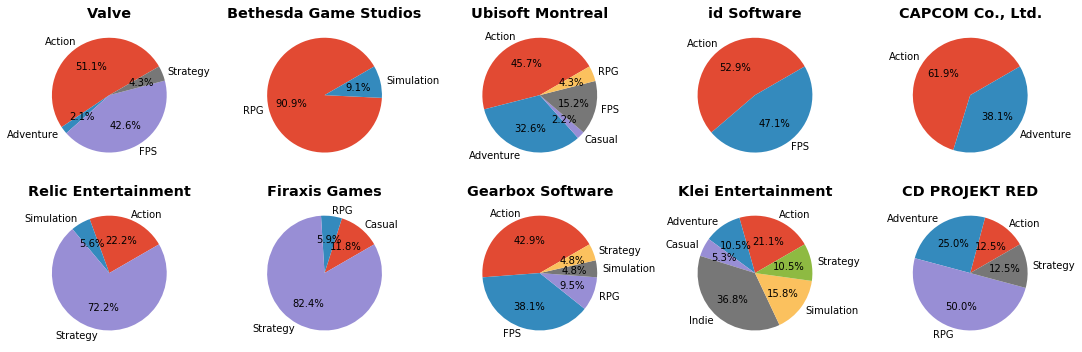

In [85]:
#plot pie charts of genres for top 10 dev
pi_chart=pi_chart.transpose()
pi_chart.set_index(top_dev.index)

fig, axes = plt.subplots(2, 5, figsize=(18, 6))

for i, (idx, row) in enumerate(pi_chart.set_index(top_dev.index).iterrows()):
    ax = axes[i // 5, i % 5]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, labels=row.index, autopct='%1.1f%%', startangle=30)
    ax.set_title(idx, fontweight='bold')

fig.subplots_adjust(wspace=.5)

Most top developers focus on 1-2 genres. Most popular genres among top developers are Action, RPG, Strategy and Adventure.

### Top 10 publishers

In [86]:
#pivot table for developers
pub_table = pd.pivot_table(df,index='publisher', values=['appid','price','total_ratings','rating','owners'], 
    aggfunc={'appid':'count','price':np.mean,'total_ratings':np.mean,'rating':np.mean,'owners':np.sum}).rename(
    {'appid':'game_num','price':'avg_price','total_ratings':'avg_total_ratings','rating':'avg_rating','owners':'sum_owners'}, axis=1)

dev_score(pub_table)
top_pub = pub_table.sort_values('dev_score', ascending=False).rename({'dev_score':'pub_score'},axis=1).head(10)
top_pub

,game_num,sum_owners,avg_price,avg_rating,avg_total_ratings,pub_score
publisher,,,,,,
Valve,30,510750000,6.692333,0.873341,197026.933333,0.800905
Ubisoft,112,81185000,20.097500,0.722535,10291.366071,0.687178
SEGA,91,78145000,21.308242,0.762820,5404.967033,0.684368
Devolver Digital,72,34800000,15.018194,0.804803,4833.986111,0.669310
Square Enix,106,72850000,17.377547,0.714637,6898.471698,0.667875
Bethesda Softworks,35,68035000,21.562571,0.781213,27799.314286,0.659883
2K,59,78030000,22.024068,0.681224,13007.050847,0.622788
Electronic Arts,33,43085000,18.626364,0.785201,6492.848485,0.617256
Paradox Interactive,56,41615000,17.936607,0.708894,7270.910714,0.607100


In [103]:
top_list=[]
pi_chart = pd.DataFrame()
for pub in top_pub.index:
    top_game = df[df['publisher'] == pub].sort_values(by='rating', ascending=False)
    pi_chart[pub] = top_game.iloc[:,-10:].sum()
    top_list.append( ', '.join([i for i in top_game.name[:5]]))
top_pub['top_5_game'] = top_list
pd.set_option('display.max_colwidth', 300)
top_pub[['pub_score', 'top_5_game']]

,pub_score,top_5_game
publisher,,
Valve,0.800905,"Portal 2, Portal, Counter-Strike, Left 4 Dead 2, Half-Life 2"
Ubisoft,0.687178,"South Park™: The Stick of Truth™, Valiant Hearts: The Great War™ / Soldats Inconnus : Mémoires de la Grande Guerre™, Child of Light, Dark Messiah of Might & Magic, Trackmania United Forever Star Edition"
SEGA,0.684368,"Total War: MEDIEVAL II – Definitive Edition, Warhammer® 40,000: Dawn of War® - Dark Crusade, Warhammer® 40,000: Dawn of War® - Soulstorm, Warhammer® 40,000: Dawn of War® - Game of the Year Edition, Alien: Isolation"
Devolver Digital,0.669310,"Hotline Miami, The Expendabros, Broforce, The Talos Principle, Downwell"
Square Enix,0.667875,"Life is Strange - Episode 1, Tomb Raider, Supreme Commander: Forged Alliance, Deus Ex: Game of the Year Edition, Life is Strange: Before the Storm"
Bethesda Softworks,0.659883,"Dishonored, Fallout: New Vegas, The Elder Scrolls V: Skyrim, The Elder Scrolls IV: Oblivion® Game of the Year Edition, The Elder Scrolls III: Morrowind® Game of the Year Edition"
2K,0.622788,"Sid Meier's Civilization® V, BioShock Infinite, XCOM: Enemy Unknown, Mafia II, Borderlands 2"
Electronic Arts,0.617256,"Mass Effect 2, Dead Space™ 2, Mass Effect, Dragon Age: Origins, Dragon Age: Origins - Ultimate Edition"
Paradox Interactive,0.607100,"Prison Architect, Cities: Skylines, Magicka, Knights of Honor, Crusader Kings II"


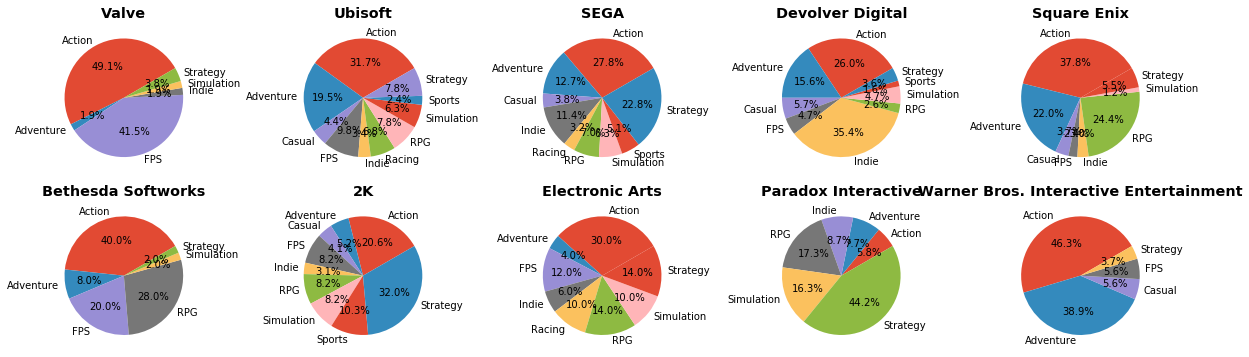

In [88]:
pi_chart=pi_chart.transpose()
pi_chart.set_index(top_pub.index)
#plot pie charts of genres for top 10 publisher
fig, axes = plt.subplots(2, 5, figsize=(20, 6))

for i, (idx, row) in enumerate(pi_chart.set_index(top_pub.index).iterrows()):
    ax = axes[i // 5, i % 5]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, labels=row.index, autopct='%1.1f%%', startangle=30)
    ax.set_title(idx, fontweight='bold')

fig.subplots_adjust(wspace=.5)

Compared to the pie charts of top developers, top publishers show more variety in game genres published. Still, Action, Adventure, Strategy games are among the most popular genres.

### Top publishers stacked bar chart over time

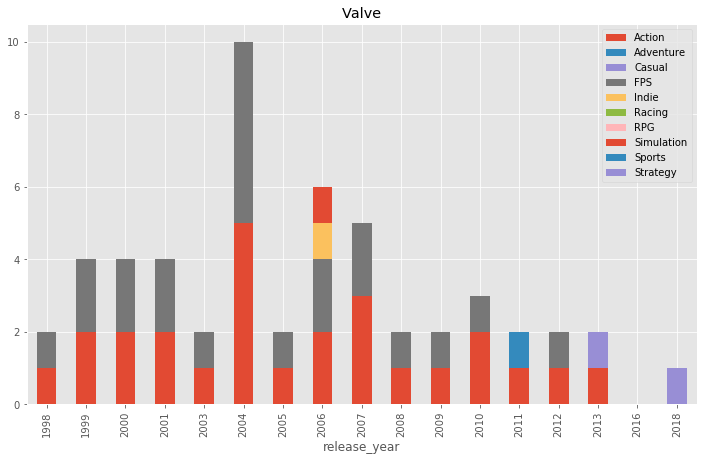

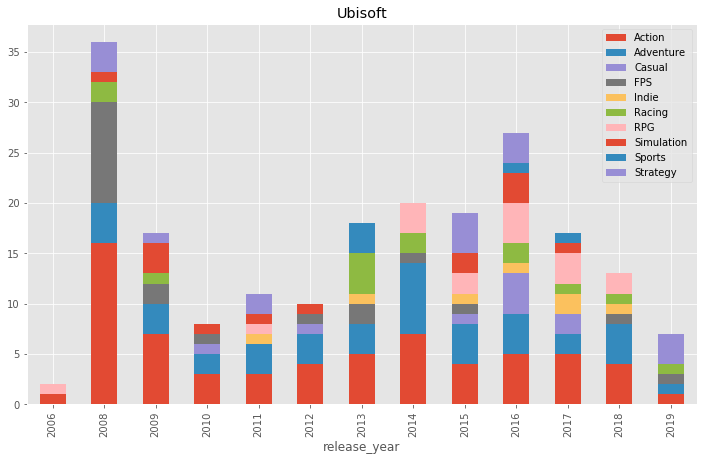

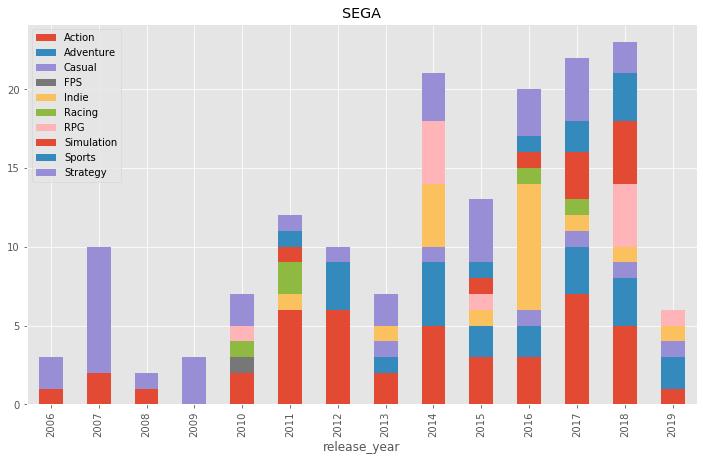

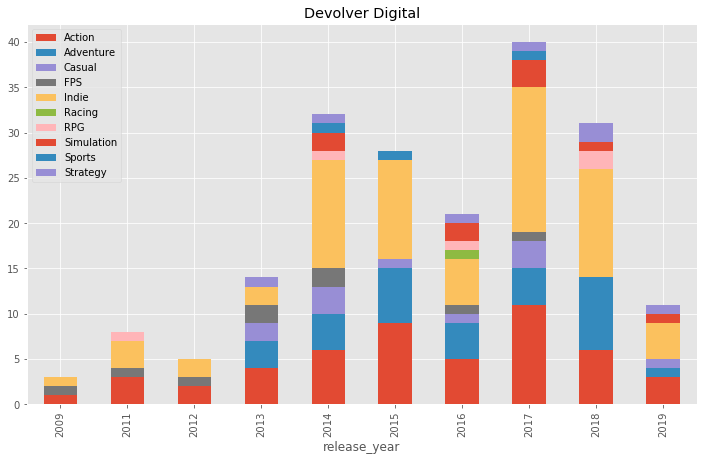

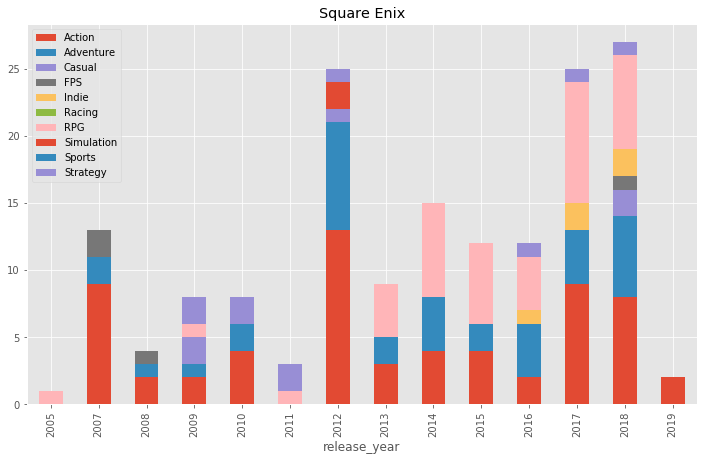

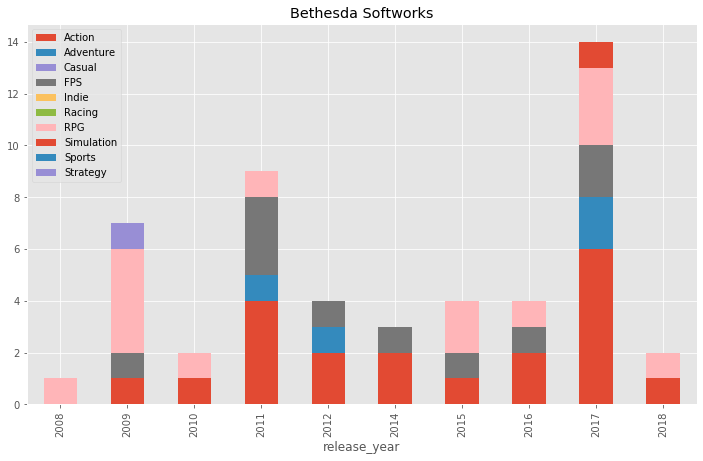

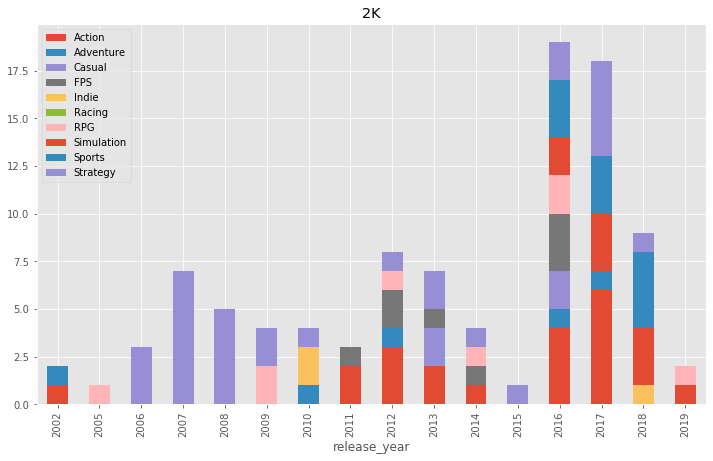

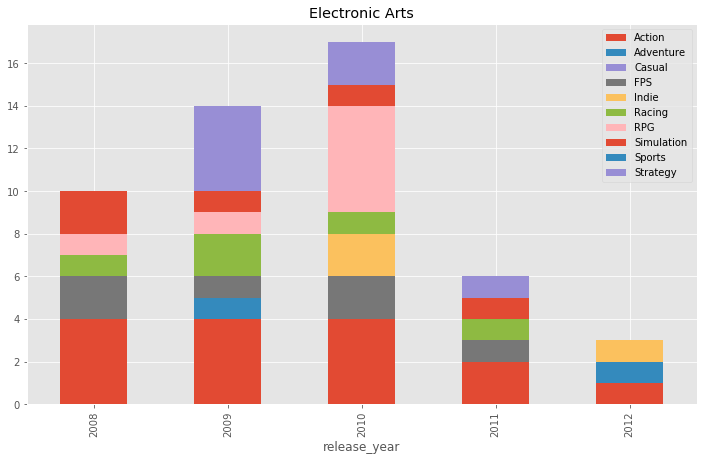

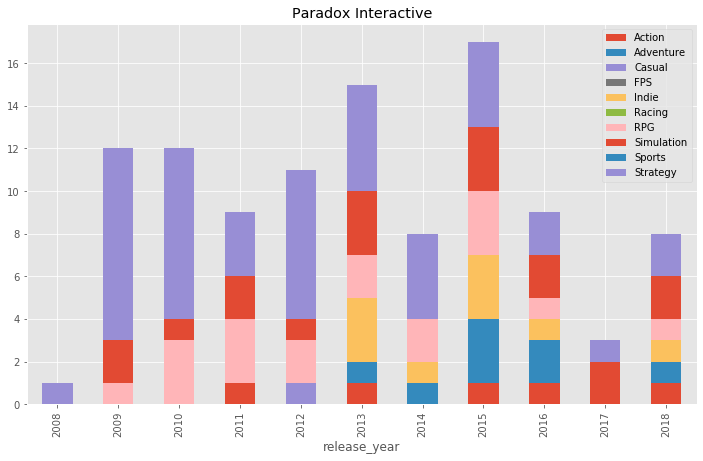

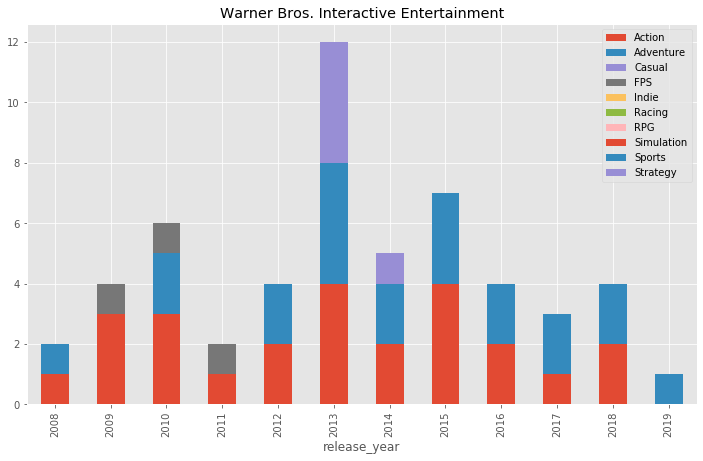

In [106]:
for pub in top_pub.index:
    pub_df=df[df['publisher'] == pub].groupby('release_year').sum()
    pub_df.loc[:,['Action','Adventure','Casual','FPS','Indie','Racing','RPG','Simulation','Sports','Strategy']].plot.bar(stacked=True,figsize=(12,7), title=pub)